In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (classification_report, confusion_matrix)
import seaborn as sns
import pandas as pd
from torch.utils.data import SubsetRandomSampler, DataLoader
import time
import torch.nn.functional as F
import optuna  
import random

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
num_epchs = 15 
batch_size = 128
valid_size = 0.1

In [ ]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

In [6]:
transform_train_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_train_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [ ]:
def get_train_valid_indices(train_dataset):
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.seed(42)
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    return train_idx, valid_idx

In [ ]:
def get_data_loaders(transform_train, train_idx, valid_idx):
    train_ds = torchvision.datasets.CIFAR10(root='./data',
                                            train=True,
                                            download=True,
                                            transform=transform_train)

    test_ds = torchvision.datasets.CIFAR10(root='./data',
                                           train=False,
                                           download=True,
                                           transform=transform_test)

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_ldr = DataLoader(train_ds,
                              batch_size=batch_size,
                              sampler=train_sampler,
                              num_workers=2)

    valid_ldr = DataLoader(train_ds,
                              batch_size=batch_size,
                              sampler=valid_sampler,
                              num_workers=2)

    test_ldr = DataLoader(test_ds,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=2)
    return train_ldr, valid_ldr, test_ldr

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the number of correct predictions over the k top predictions"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k)
    return res 

In [ ]:
def objective(trial, transform_train, train_idx, valid_idx):
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.5, 0.99)
    else:
        momentum = None

    train_ldr, valid_ldr, _ = get_data_loaders(transform_train, train_idx, valid_idx)
    model = models.alexnet(pretrained=False)
    model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1) 
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10) 
    model = model.to(device)
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    for epoch in range(num_epchs):
        model.train()
        for images, labels in train_ldr:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for images, labels in valid_ldr:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        valid_acc = 100 * correct_valid / total_valid
        trial.report(valid_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        scheduler.step()
    return valid_acc

In [ ]:

def run_hyperparameter_tuning(transform_train, experiment_name, train_idx, valid_idx):
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(lambda trial: objective(trial, transform_train, train_idx, valid_idx), n_trials=10)

    print(f"\nBest hyperparameters for {experiment_name}:")
    print(study.best_trial.params)
    print(f"Best validation accuracy: {study.best_value:.2f}%")

    return study.best_trial.params
train_dataset_for_indices = torchvision.datasets.CIFAR10(root='./data',
                                                         train=True,
                                                         download=True,
                                                         transform=transform_train_no_aug)
train_idx_global, valid_idx_global = get_train_valid_indices(train_dataset_for_indices)

Files already downloaded and verified


In [ ]:
print("Running hyperparameter tuning with data augmentation...")
best_params_aug = run_hyperparameter_tuning(transform_train_augmented, "With_Data_Augmentation", train_idx_global, valid_idx_global)

[I 2024-11-09 02:48:23,235] A new study created in memory with name: no-name-bb09e3e1-c7e8-4464-b6c4-b1f201f9b384


Running hyperparameter tuning with data augmentation...
Files already downloaded and verified
Files already downloaded and verified


c:\Users\mails\miniconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mails\miniconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[I 2024-11-09 02:55:50,209] Trial 0 finished with value: 74.54 and parameters: {'optimizer': 'SGD', 'lr': 0.015702970884055395, 'weight_decay': 0.0006251373574521745, 'momentum': 0.5764491338167939}. Best is trial 0 with value: 74.54.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 03:04:56,438] Trial 1 finished with value: 9.52 and parameters: {'optimizer': 'Adam', 'lr': 0.0396760507705299, 'weight_decay': 0.0006358358856676254}. Best is trial 0 with value: 74.54.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 03:14:26,746] Trial 2 finished with value: 9.72 and parameters: {'optimizer': 'Adam', 'lr': 0.0812324508558869, 'weight_decay': 0.00314288089084011}. Best is trial 0 with value: 74.54.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 03:23:10,257] Trial 3 finished with value: 80.5 and parameters: {'optimizer': 'Adam', 'lr': 0.0003549878832196505, 'weight_decay': 8.17949947521167e-05}. Best is trial 3 with value: 80.5.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 03:31:52,446] Trial 4 finished with value: 75.82 and parameters: {'optimizer': 'Adam', 'lr': 0.0007476312062252305, 'weight_decay': 0.000684792009557478}. Best is trial 3 with value: 80.5.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 03:32:23,754] Trial 5 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 03:32:54,975] Trial 6 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 03:33:28,555] Trial 7 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 03:41:32,437] Trial 8 finished with value: 81.4 and parameters: {'optimizer': 'Adam', 'lr': 0.00019634341572933326, 'weight_decay': 0.0011290133559092666}. Best is trial 8 with value: 81.4.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 03:42:06,628] Trial 9 pruned. 



Best hyperparameters for With_Data_Augmentation:
{'optimizer': 'Adam', 'lr': 0.00019634341572933326, 'weight_decay': 0.0011290133559092666}
Best validation accuracy: 81.40%


In [ ]:
print("\nRunning hyperparameter tuning without data augmentation...")
best_params_no_aug = run_hyperparameter_tuning(transform_train_no_aug, "Without_Data_Augmentation", train_idx_global, valid_idx_global)

[I 2024-11-09 03:42:06,669] A new study created in memory with name: no-name-648f2348-e086-4480-a816-2dc611adf4c6



Running hyperparameter tuning without data augmentation...
Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 03:50:45,927] Trial 0 finished with value: 78.98 and parameters: {'optimizer': 'SGD', 'lr': 0.015702970884055395, 'weight_decay': 0.0006251373574521745, 'momentum': 0.5764491338167939}. Best is trial 0 with value: 78.98.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 04:00:06,875] Trial 1 finished with value: 10.06 and parameters: {'optimizer': 'Adam', 'lr': 0.0396760507705299, 'weight_decay': 0.0006358358856676254}. Best is trial 0 with value: 78.98.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 04:08:34,945] Trial 2 finished with value: 10.06 and parameters: {'optimizer': 'Adam', 'lr': 0.0812324508558869, 'weight_decay': 0.00314288089084011}. Best is trial 0 with value: 78.98.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 04:17:33,992] Trial 3 finished with value: 80.84 and parameters: {'optimizer': 'Adam', 'lr': 0.0003549878832196505, 'weight_decay': 8.17949947521167e-05}. Best is trial 3 with value: 80.84.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 04:25:33,917] Trial 4 finished with value: 78.9 and parameters: {'optimizer': 'Adam', 'lr': 0.0007476312062252305, 'weight_decay': 0.000684792009557478}. Best is trial 3 with value: 80.84.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 04:26:03,982] Trial 5 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 04:26:36,065] Trial 6 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 04:27:08,555] Trial 7 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 04:35:48,242] Trial 8 finished with value: 80.86 and parameters: {'optimizer': 'Adam', 'lr': 0.00019634341572933326, 'weight_decay': 0.0011290133559092666}. Best is trial 8 with value: 80.86.


Files already downloaded and verified
Files already downloaded and verified


[I 2024-11-09 04:36:25,625] Trial 9 pruned. 



Best hyperparameters for Without_Data_Augmentation:
{'optimizer': 'Adam', 'lr': 0.00019634341572933326, 'weight_decay': 0.0011290133559092666}
Best validation accuracy: 80.86%


In [ ]:
def train_and_evaluate(best_params, transform_train, experiment_name, train_idx, valid_idx):
    train_ldr, valid_ldr, test_ldr = get_data_loaders(transform_train, train_idx, valid_idx)
    model = models.alexnet(pretrained=False)
    model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10) 
    model = model.to(device)
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()

    optimizer_name = best_params['optimizer']
    lr = best_params['lr']
    weight_decay = best_params['weight_decay']
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        momentum = best_params['momentum']
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    trainLosses = []
    validLosses = []
    train_accu = []
    valid_accu = []

    best_valid_acc = 0.0 
    best_model_state = None 

    total_training_time = 0.0
    for epoch in range(num_epchs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_ldr:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_ldr.sampler)
        epoch_acc = 100 * correct / total
        trainLosses.append(epoch_loss)
        train_accu.append(epoch_acc)
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for images, labels in valid_ldr:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
        valid_loss = valid_loss / len(valid_ldr.sampler)
        valid_acc = 100 * correct_valid / total_valid
        validLosses.append(valid_loss)
        valid_accu.append(valid_acc)
        epoch_duration = time.time() - epoch_start_time
        total_training_time += epoch_duration
        print(f'[{experiment_name}] Epoch [{epoch+1}/{num_epchs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, '
              f'Time: {epoch_duration:.2f}s')
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model_state = model.state_dict()
            torch.save(best_model_state, f'best_model_{experiment_name}.pth')
            print(f'[{experiment_name}] Best model saved at epoch {epoch+1} with validation accuracy: {best_valid_acc:.2f}%')
        scheduler.step()
    model.load_state_dict(best_model_state)
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_preds = []
    all_labels = []

    top1_correct = 0
    top3_correct = 0 
    inference_start_time = time.time()

    with torch.no_grad():
        for images, labels in test_ldr:
            images = images.to(device)
            labels = labels.to(device)
            batch_size = images.size(0)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * batch_size
            correct1, correct3 = accuracy(outputs, labels, topk=(1, 3))
            top1_correct += correct1.item()
            top3_correct += correct3.item()
            total_test += batch_size
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    inference_duration = time.time() - inference_start_time
    average_inference_time = inference_duration / total_test

    test_loss = test_loss / len(test_ldr.dataset)
    top1_acc = 100 * top1_correct / total_test
    top3_acc = 100 * top3_correct / total_test 

    print(f'[{experiment_name}] Test Loss: {test_loss:.4f}, Top-1 Test Acc: {top1_acc:.2f}%, Top-3 Test Acc: {top3_acc:.2f}%')
    print(f'Inference Time: {inference_duration:.2f}s, Average per image: {average_inference_time*1000:.2f}ms')
    print(f'Total Training Time: {total_training_time:.2f}s')
    metrics = pd.DataFrame({
        'epoch': np.arange(1, num_epchs+1),
        'train_loss': trainLosses,
        'valid_loss': validLosses,
        'train_accuracy': train_accu,
        'valid_accuracy': valid_accu
    })
    metrics.to_csv(f'metrics_{experiment_name}.csv', index=False)
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Validation Loss ({experiment_name})")
    plt.plot(metrics['epoch'], metrics['train_loss'], label="Train Loss")
    plt.plot(metrics['epoch'], metrics['valid_loss'], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'loss_curve_{experiment_name}.png')
    plt.show()
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Validation Accuracy ({experiment_name})")
    plt.plot(metrics['epoch'], metrics['train_accuracy'], label="Train Accuracy")
    plt.plot(metrics['epoch'], metrics['valid_accuracy'], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.savefig(f'accuracy_curve_{experiment_name}.png')
    plt.show()
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_ldr.dataset.classes))
    report = classification_report(all_labels, all_preds, target_names=test_ldr.dataset.classes, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f'classification_report_{experiment_name}.csv', index=True)
    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_ldr.dataset.classes, yticklabels=test_ldr.dataset.classes, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix ({experiment_name})')
    plt.savefig(f'confusion_matrix_{experiment_name}.png')
    plt.show()
    cm_df = pd.DataFrame(cm, index=test_ldr.dataset.classes, columns=test_ldr.dataset.classes)
    cm_df.to_csv(f'confusion_matrix_{experiment_name}.csv')
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-3 Accuracy: {top3_acc:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
[With_Augmentation] Epoch [1/15], Train Loss: 1.7587, Train Acc: 33.29%, Valid Loss: 1.4293, Valid Acc: 46.24%, Time: 36.96s
[With_Augmentation] Best model saved at epoch 1 with validation accuracy: 46.24%
[With_Augmentation] Epoch [2/15], Train Loss: 1.3658, Train Acc: 49.84%, Valid Loss: 1.2651, Valid Acc: 53.80%, Time: 42.32s
[With_Augmentation] Best model saved at epoch 2 with validation accuracy: 53.80%
[With_Augmentation] Epoch [3/15], Train Loss: 1.1736, Train Acc: 57.77%, Valid Loss: 1.1055, Valid Acc: 59.36%, Time: 40.89s
[With_Augmentation] Best model saved at epoch 3 with validation accuracy: 59.36%
[With_Augmentation] Epoch [4/15], Train Loss: 1.0333, Train Acc: 63.44%, Valid Loss: 0.9902, Valid Acc: 63.70%, Time: 41.53s
[With_Augmentation] Best model saved at epoch 4 with validation accuracy: 63.70%
[With_Augmentation] Epoch [5/15], Train Loss: 0.9399, Train Acc: 66.80%, Valid Loss: 0.9885, Valid A

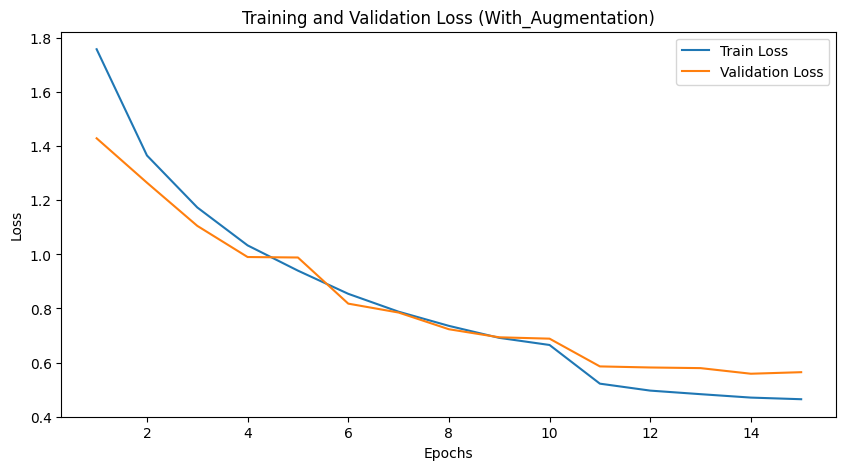

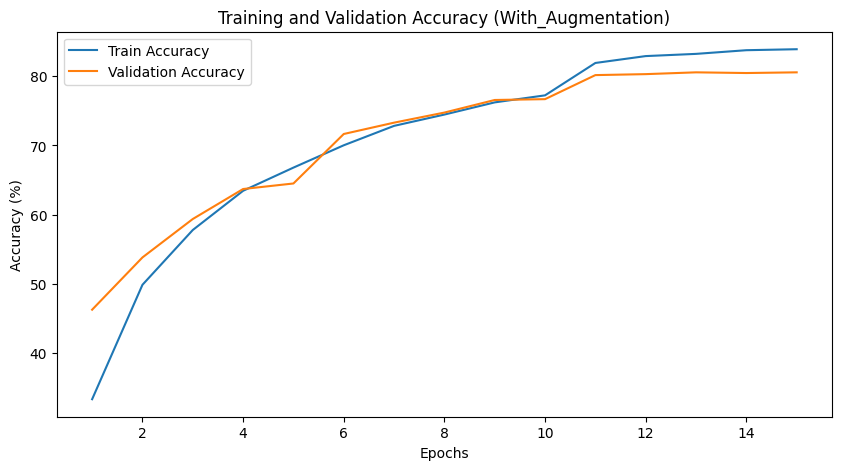

Classification Report:
              precision    recall  f1-score   support

    airplane       0.83      0.87      0.85      1000
  automobile       0.89      0.92      0.91      1000
        bird       0.79      0.70      0.74      1000
         cat       0.66      0.60      0.63      1000
        deer       0.81      0.77      0.79      1000
         dog       0.67      0.74      0.70      1000
        frog       0.82      0.90      0.86      1000
       horse       0.84      0.84      0.84      1000
        ship       0.93      0.87      0.90      1000
       truck       0.87      0.87      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Confusion Matrix:


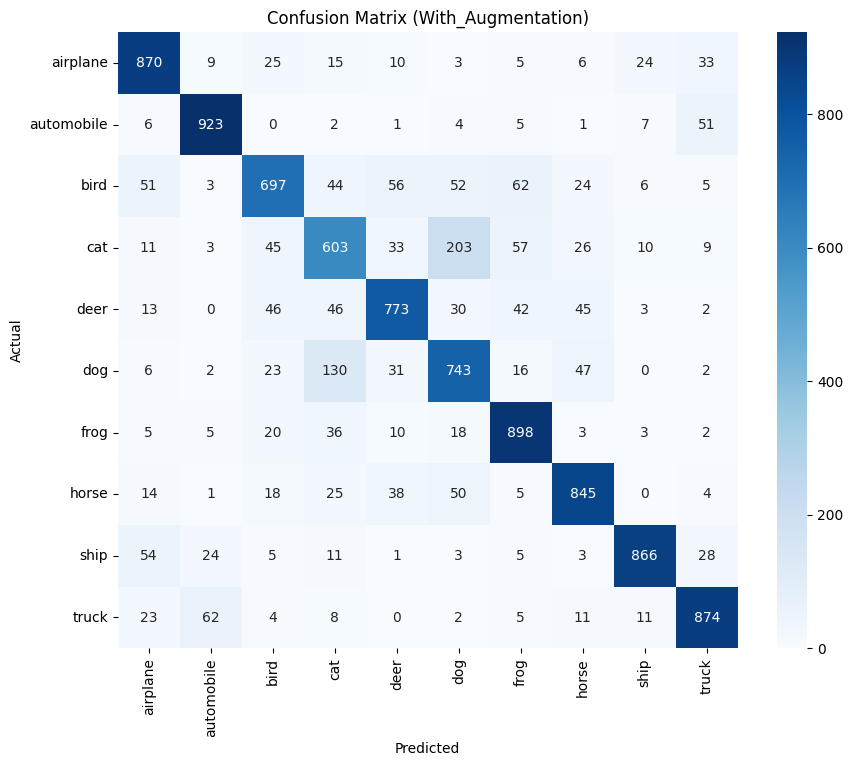

Top-1 Accuracy: 80.92%
Top-3 Accuracy: 96.14%


In [ ]:
(best_params_aug, transform_train_augmented, "With_Augmentation", train_idx_global, valid_idx_global)

Files already downloaded and verified
Files already downloaded and verified


c:\Users\mails\miniconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mails\miniconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Without_Augmentation] Epoch [1/15], Train Loss: 1.6472, Train Acc: 37.66%, Valid Loss: 1.3150, Valid Acc: 50.68%, Time: 32.51s
[Without_Augmentation] Best model saved at epoch 1 with validation accuracy: 50.68%
[Without_Augmentation] Epoch [2/15], Train Loss: 1.2104, Train Acc: 55.96%, Valid Loss: 1.1242, Valid Acc: 58.76%, Time: 30.91s
[Without_Augmentation] Best model saved at epoch 2 with validation accuracy: 58.76%
[Without_Augmentation] Epoch [3/15], Train Loss: 0.9989, Train Acc: 64.19%, Valid Loss: 0.9162, Valid Acc: 66.96%, Time: 31.45s
[Without_Augmentation] Best model saved at epoch 3 with validation accuracy: 66.96%
[Without_Augmentation] Epoch [4/15], Train Loss: 0.8495, Train Acc: 70.01%, Valid Loss: 0.8246, Valid Acc: 70.92%, Time: 30.71s
[Without_Augmentation] Best model saved at epoch 4 with validation accuracy: 70.92%
[Without_Augmentation] Epoch [5/15], Train Loss: 0.7375, Train Acc: 74.30%, Valid Loss: 0.7910, Valid Acc: 73.32%, Time: 31.28s
[Without_Augmentation] B

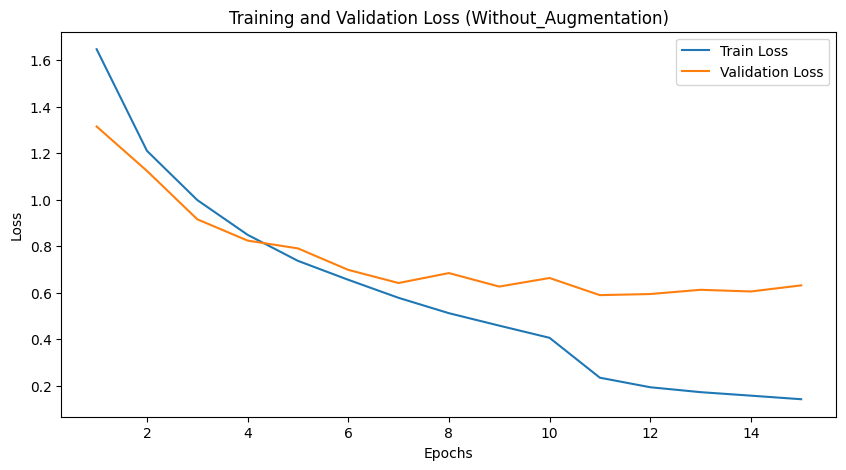

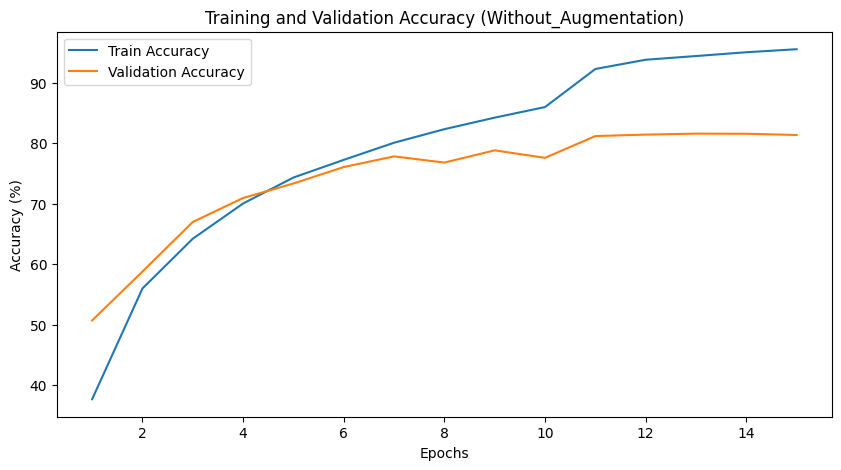

Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.86      0.84      1000
  automobile       0.89      0.92      0.90      1000
        bird       0.79      0.73      0.76      1000
         cat       0.66      0.66      0.66      1000
        deer       0.77      0.81      0.79      1000
         dog       0.74      0.73      0.73      1000
        frog       0.86      0.87      0.86      1000
       horse       0.85      0.85      0.85      1000
        ship       0.93      0.87      0.90      1000
       truck       0.86      0.87      0.86      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

Confusion Matrix:


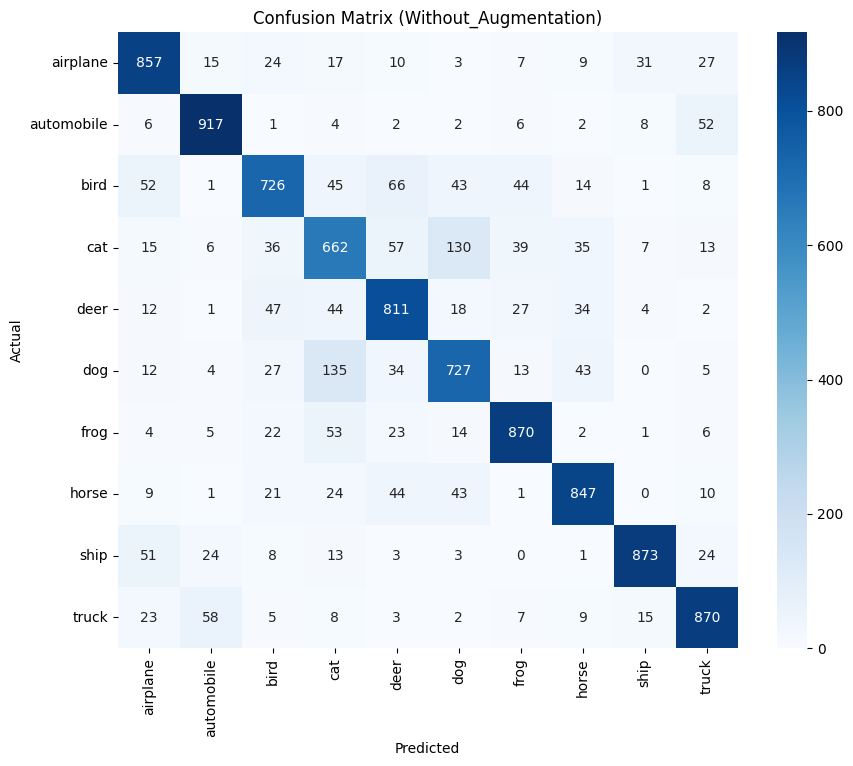

Top-1 Accuracy: 81.60%
Top-3 Accuracy: 95.98%


In [ ]:
train_and_evaluate(best_params_no_aug, transform_train_no_aug, "Without_Augmentation", train_idx_global, valid_idx_global)